In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import torch
torch.rand(10)
import torch.nn as nn
import torch.nn.functional as F

print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
print(torch.cuda.current_device())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

True
TITAN RTX
0
Using device: cuda

TITAN RTX
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
# cells_v4
# paprika_y4
 
# get number of classes in dataset
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('/home/user01/data_ssd/Talha/yolo/cells_v4/train/_classes.txt')
print(num_classes)

6


In [ ]:
#start training
#-b batch size (you should keep this low (2-4) for training to work properly)
#-s number of subdivisions in the batch, this was more relevant for the darknet framework
#-l learning rate
#-g direct training to the GPU device
#pretrained invoke the pretrained weights that we downloaded above
#classes - number of classes
#dir - where the training data is
#epoch - how long to train for
#train_label_path - path to .txt file containing labels

os.chdir('/home/user01/data_ssd/Talha/yolo/cells_v4/')

# results will be saved inside this dir in `logs`

!python /home/user01/data_ssd/Talha/yolo/pytorch-YOLOv4/train.py \
        -b 2 -s 1 -l 0.001 -g 2 \
        -pretrained /home/user01/data_ssd/Talha/yolo/pytorch-YOLOv4/cfg/yolov4.conv.137.pth \
        -classes {num_classes} \
        -dir /home/user01/data_ssd/Talha/yolo/cells_v4/train/ \
        -train_label_path /home/user01/data_ssd/Talha/yolo/cells_v4/data/train.txt \
        -epochs 100

In [17]:
# now for inference you can follow following steps
# now this cell will write the .txt files for your predictions which you can use to 
# evaluate  or analyise you modes
os.chdir('/home/user01/data_ssd/Talha/yolo/pytorch-YOLOv4/')

from my_utils import xywh_2_xyminmax, draw_boxes
import seaborn as sns
import sys, os, glob, random, cv2
from PIL import Image
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib as mpl
from tool.utils import *
mpl.rcParams['figure.dpi'] = 300

img_paths = glob.glob('/home/user01/data_ssd/Talha/yolo/cells_v4/test/*.png') + \
            glob.glob('/home/user01/data_ssd/Talha/yolo/cells_v4/test/*.jpg')
imgfile = random.choice(img_paths)
plot = False
n_classes = 6

weightfile = '/home/user01/data_ssd/Talha/yolo/cells_v4/checkpoints/Yolov4_epoch35.pth'
namesfile = '/home/user01/data_ssd/Talha/yolo/cells_v4/test/_classes.txt'
op_dir = '/home/user01/data_ssd/Talha/yolo/eval/'

filelist = [ f for f in os.listdir(op_dir)]# if f.endswith(".png") ]
for f in tqdm(filelist, desc = 'Deleting old files op_dir'):
    os.remove(os.path.join(op_dir, f))
    
model = Yolov4(n_classes=n_classes)

pretrained_dict = torch.load(weightfile, map_location=torch.device('cuda'))
model.load_state_dict(pretrained_dict)

use_cuda = 1
if use_cuda:
    model.cuda()

for i in trange(len(img_paths), desc='Writing files for Eval'):
    imgfile = img_paths[i]
    img = Image.open(imgfile).convert('RGB')
    
    '''
    The output format of boxes is 
    <x><y><w><h><conf1><conf2><class_id>
    ignore conf1 use **conf2** as confidence
    '''
    sized = img.resize((608, 608))
    class_names = load_class_names(namesfile)
    boxes = do_detect(model, sized, 0.5, n_classes,0.4, use_cuda)
    
    if plot:
        plot_boxes(img, boxes, 'predictions2.jpg', class_names)
    
    boxes = np.asarray(boxes).astype(np.float)
    name = os.path.basename(imgfile)[:-4]
    
    coords_xywh = np.zeros((boxes.shape[0], 4)) # droping 5th value
    confd = np.zeros((boxes.shape[0], 1))
    class_ids = np.zeros((boxes.shape[0], 1))
    # assign
    coords_xywh = boxes[:,0:4] # coords
    confd = boxes[:,5] # confidence
    class_ids = boxes[:,6] # class id
    
    coords_xyminmax = []
    det_classes = []
    for i in range(boxes.shape[0]):
        coords_xyminmax.append(xywh_2_xyminmax(img.size[0], img.size[1], coords_xywh[i]))
        det_classes.append(class_names[int(class_ids[i])])
    
    all_bounding_boxnind = []
    for i in range(boxes.shape[0]):
        
        bounding_box = [0.0] * 6
        
        bounding_box[0] = det_classes[i]
        bounding_box[1] = confd[i]
        bounding_box[2] = coords_xyminmax[i][0]
        bounding_box[3] = coords_xyminmax[i][1]
        bounding_box[4] = coords_xyminmax[i][2]
        bounding_box[5] = coords_xyminmax[i][3]
        
        bounding_box = str(bounding_box)[1:-1]# remove square brackets
        bounding_box = bounding_box.replace("'",'')# removing inverted commas around class name
        bounding_box = "".join(bounding_box.split())# remove spaces in between **here dont give space inbetween the inverted commas "".
        all_bounding_boxnind.append(bounding_box)
    
    all_bounding_boxnind = ' '.join(map(str, all_bounding_boxnind))# convert list to string
    all_bounding_boxnind=list(all_bounding_boxnind.split(' ')) # convert strin to list
    # replacing commas with spaces
    for i in range(len(all_bounding_boxnind)):
        all_bounding_boxnind[i] = all_bounding_boxnind[i].replace(',',' ')
    for i in range(len(all_bounding_boxnind)):
    # check if file exiscts else make new
        with open(op_dir +'{}.txt'.format(name), "a+") as file_object:
            # Move read cursor to the start of file.
            file_object.seek(0)
            # If file is not empty then append '\n'
            data = file_object.read(100)
            if len(data) > 0 :
                file_object.write("\n")
            # Append text at the end of file
            file_object.write(all_bounding_boxnind[i])

Writing files for Eval: 100%|██████████| 36/36 [00:05<00:00,  6.82it/s]


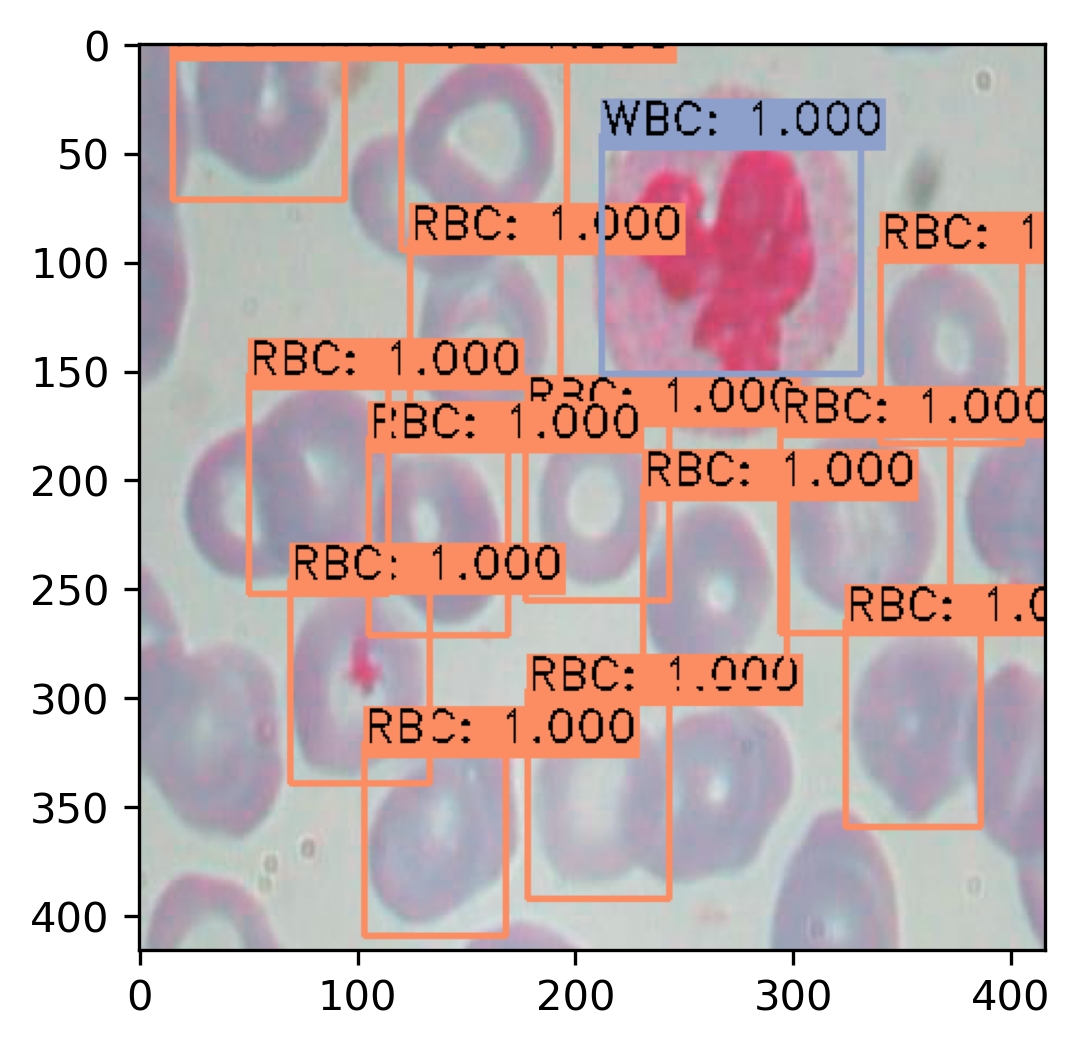

In [18]:
# to see op predictions
imgfile = img_paths[10]
img = Image.open(imgfile).convert('RGB')
sized = img.resize((608, 608))
class_names = load_class_names(namesfile)
boxes = do_detect(model, sized, 0.5, n_classes,0.4, use_cuda)

boxes = np.asarray(boxes).astype(np.float)
name = os.path.basename(imgfile)[:-4]

coords_xywh = np.zeros((boxes.shape[0], 4)) # droping 5th value
confd = np.zeros((boxes.shape[0], 1))
class_ids = np.zeros((boxes.shape[0], 1))
# assign
coords_xywh = boxes[:,0:4] # coords
confd = boxes[:,5] # confidence
class_ids = boxes[:,6] # class id

coords_xyminmax = []
det_classes = []
for i in range(boxes.shape[0]):
    coords_xyminmax.append(xywh_2_xyminmax(img.size[0], img.size[1], coords_xywh[i]))
    det_classes.append(class_names[int(class_ids[i])])
    
img  = cv2.imread(imgfile)
t = np.asarray(coords_xyminmax)
op = draw_boxes(img, confd, t, det_classes, class_names, order='xy_minmax', analysis=False)
plt.imshow(op)

In [10]:
#looking at the weights that our model has saved during training
os.chdir('/home/user01/data_ssd/Talha/yolo/cells_v4/')
!ls checkpoints

Yolov4_epoch100.pth  Yolov4_epoch32.pth  Yolov4_epoch55.pth  Yolov4_epoch78.pth
Yolov4_epoch10.pth   Yolov4_epoch33.pth  Yolov4_epoch56.pth  Yolov4_epoch79.pth
Yolov4_epoch11.pth   Yolov4_epoch34.pth  Yolov4_epoch57.pth  Yolov4_epoch7.pth
Yolov4_epoch12.pth   Yolov4_epoch35.pth  Yolov4_epoch58.pth  Yolov4_epoch80.pth
Yolov4_epoch13.pth   Yolov4_epoch36.pth  Yolov4_epoch59.pth  Yolov4_epoch81.pth
Yolov4_epoch14.pth   Yolov4_epoch37.pth  Yolov4_epoch5.pth   Yolov4_epoch82.pth
Yolov4_epoch15.pth   Yolov4_epoch38.pth  Yolov4_epoch60.pth  Yolov4_epoch83.pth
Yolov4_epoch16.pth   Yolov4_epoch39.pth  Yolov4_epoch61.pth  Yolov4_epoch84.pth
Yolov4_epoch17.pth   Yolov4_epoch3.pth	 Yolov4_epoch62.pth  Yolov4_epoch85.pth
Yolov4_epoch18.pth   Yolov4_epoch40.pth  Yolov4_epoch63.pth  Yolov4_epoch86.pth
Yolov4_epoch19.pth   Yolov4_epoch41.pth  Yolov4_epoch64.pth  Yolov4_epoch87.pth
Yolov4_epoch1.pth    Yolov4_epoch42.pth  Yolov4_epoch65.pth  Yolov4_epoch88.pth
Yolov4_epoch20.pth   Yolov4_epoch43.pth  Y

In [13]:
#choose random test image
import os
test_images = [f for f in os.listdir('/home/user01/data_ssd/Talha/yolo/cells_v4/test') if f.endswith('.jpg')]
import random
img_path = "/home/user01/data_ssd/Talha/yolo/cells_v4/test/" + random.choice(test_images);
print(img_path)

/home/user01/data_ssd/Talha/yolo/cells_v4/test/BloodImage_00385_jpg.rf.865551dd16b189945cbba0fe51baa151.jpg


In [14]:
'''
Or open my_inference.py file to get eval(.txt) files
'''

!python /home/user01/data_ssd/Talha/yolo/pytorch-YOLOv4/models.py \
        {num_classes} \
        /home/user01/data_ssd/Talha/yolo/cells_v4/checkpoints/Yolov4_epoch100.pth \
        {img_path} \
        /home/user01/data_ssd/Talha/yolo/cells_v4/test/_classes.txt

/home/user01/data_ssd/Talha/yolo/pytorch-YOLOv4/tool/utils.py:16: RuntimeWarning: overflow encountered in exp
  return 1.0 / (np.exp(-x) + 1.)
RBC: 1.000000
RBC: 1.000000
RBC: 1.000000
RBC: 1.000000
RBC: 1.000000
RBC: 1.000000
Platelets: 1.000000
RBC: 1.000000
RBC: 1.000000
RBC: 1.000000
RBC: 1.000000
WBC: 1.000000
RBC: 1.000000
RBC: 1.000000
RBC: 1.000000
RBC: 1.000000
Platelets: 1.000000
RBC: 1.000000
RBC: 1.000000
RBC: 1.000000
Platelets: 0.999999
RBC: 1.000000
save plot results to predictions.jpg


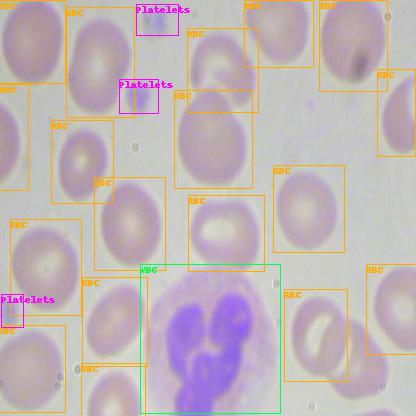

In [15]:
#visualize inference
from IPython.display import Image
Image('predictions.jpg')